### **Part 2: Enhance Chatbot with Tools**
 1. Specify tavily api key (tavily is used to search internet like google but designed for llms)
 2. Define the tool TavilySearchResults to inovke 
 3. Rebuild the chatbot from part one with **bind_tools** added to the llm. (this tells llm how to format json get/post requests when using the tavily search api)
 4. Add tools to a new node in the **STATEGRAPH** to create function to run tools if called 
    - ***BasicToolNode*** is a class that checks the most recent message in the ***STATE*** instance and calls tools if the message contains **tool_calls**. Langchain provides a prebuilt ***ToolNode*** class to abstract this if building from scratch is to painful
 5. Define ***conditional edges*** to route the contorl flow from one note to another. *Conditional Edges* usually ocntain  'if' statements to route to different nodes depending on the current graph state.  These functions receive the current graph state and return a string or list of strings indicating which node(s) to call next.
    - Note: the prebuilt *tools_condition()* method should be used in production , we define our tool router manually for instructive purposes


In [3]:
#Import API Keys        
_root = "/home/zjc1002/Mounts/code/admin/"

In [4]:
import sys, json 
from typing import Annotated
from typing_extensions import TypedDict
from IPython.display import Image, display
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableConfig
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langchain_community.tools.tavily_search import TavilySearchResults

# Model speicifc functions 
from anthropic import Anthropic
from langchain_anthropic import ChatAnthropic

# Custom functions
sys.path.append(_root)
from api_keys import _api_keys
from sys_ops import _set_env

# This internet tool requires an API key to be set in the environment variable TAVILY_API_KEY
_set_env("TAVILY_API_KEY"
         ,value =  _api_keys['TAVILY_API_KEY'])

#SET ANTHROPIC API KEY ENV VAR
_set_env("ANTHROPIC_API_KEY"
         ,value =  _api_keys['ANTHROPIC_API_KEY'])

# Specifcy Anthropic model to use 
_model_id = "claude-3-haiku-20240307"

### Create/Define Tools to use in graph

In [3]:
#DEFINE THE TOOL 
tool = TavilySearchResults(max_results=1)
tools = [tool]

# The tool will return a dictionary with the results
#print(f"<b>THIS IS A TEST TO SHOW FORMAT OF TAVILY RESPONSE:</b> \n\n{tool.invoke('who is zachary carideo?')}")

### Define the State Graph

In [4]:
# The StateGraph is a way to define the state of the application and the nodes that will be used to process the state
# Define the State class that represents the current state of the conversation
class State(TypedDict):
    """
     The State Class contains a messages field that holds the conversation history
     The Annotated type hint indicates that this field uses the add_messages function 
     to properly append new messages to the existing conversation
    """
    messages: Annotated[list, add_messages]


class ConifgSchema(TypedDict):
    use_tavily: bool 

# NOTE: You can use the  config to pass parameters into the tools you are calling(here Tavily Search parameters)
def chatbot(state: State
            , config: RunnableConfig
            )-> dict:
    """
    The chatbot node function takes the current State as input and returns a dictionary containing
    an updated messages list under the key "messages".
    NOTE: This is the basic pattern for all LangGraph node functions.
    """

    # The state is a dictionary that contains the current state of the conversation
    # The config is a dictionary that contains the parameters for the LLM
    _use_internet = config['configurable'].get("use_tavily",False)
    _message = llm_with_tools.invoke(state["messages"])
    return {"messages": [_message]}


# Add a BasicToolNode that checks the most recent message in the state and calls tools if the message contains tool_calls. 
# It relies on the LLM's tool_calling support, which is available in Anthropic, OpenAI, Google Gemini, and a number of other LLM providers.
class BasicToolNode: 

    """A node that runs the tools requested in the  last AIMessage"""

    def __init__(self
                 ,tools: list
                 ) -> None: 
        
        self.tools_by_name = {t.name: t for t in tools}
    
    def __call__(self,inputs: dict): 

        # Check the most recent message in the state and call tools if the message contains tool_calls
        # check if the last message is a tool call
        # if the last message is a tool call, run the tools
        # if the last message is not a tool call, return the inputs
        #Note: in python empty collections(like []) are considered False, while non-empty collections are considered True
        if messages := inputs.get("messages",[]): 
            message = messages[-1]
            print(isinstance(message, ToolMessage))
        else: 
            raise ValueError('No Messages Found in inputs')


        outputs = []
        for tool_call in message.tool_calls: 
            
            #run the tool and get the result
            print(f"Running tool: {tool_call['name']}")
            print(f"Tool call args: {tool_call['args']}")

            tool_result = self.tools_by_name[tool_call['name']].invoke(tool_call['args']
                                                                       )
            #add the result to the outputs list
            outputs.append(
                ToolMessage(content=json.dumps(tool_result),
                            name = tool_call['name'], 
                            tool_call_id = tool_call["id"]
                            )
            )

        return {'messages': outputs}


#BUILD IT 

#use the custom State to define how the Stategraph operates
graph_builder = StateGraph(State)

#select the model from ANRTHROPIC you want to use as your chatbot
llm = ChatAnthropic(model=_model_id)

# ADD TOOLS TO THE LLM 
# Tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)

# Add the chatbot node to the graph
# The chatbot node is a function that takes the current state and returns a new state
graph_builder.add_node("chatbot", chatbot)

# Add the BasicToolNode to the graph
# The BasicToolNode is a node that runs the tools requested in the last AIMessage
tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

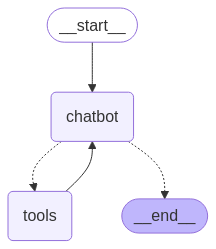

In [5]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """

    #get the message if it exists
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    
    #If message exists check if a tool has been referenced 
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools"
     , END: END},
)

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)
    pass


In [7]:

def stream_graph_updates(user_input: str):
    
    """
    This function takes the user input and streams the graph updates
    It uses the graph to process the user input and returns the updated state
    The graph is a StateGraph that contains the nodes and edges that define the conversation
    """

    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)
            print(value["messages"][-1].response_metadata.keys())
            try: 
                print(f"Message ID: {value['messages'][-1].response_metadata['id']}")
                print(f"Model Used: {value['messages'][-1].response_metadata['model']}")
                print(f"Chat Stop Reason: {value['messages'][-1].response_metadata['stop_reason']}")
                print(f"Chat Stop Sequence: {value['messages'][-1].response_metadata['stop_sequence']}")
                print(f"Chat usage: {value['messages'][-1].response_metadata['usage']}")
            except:
                print("No response metadata found")
            print("--------------------------------------------------")

#RUN IT 
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: [{'id': 'toolu_01U3XkQRpm9eeaiJLZPZ18QB', 'input': {'query': 'who owns the model being used as a chatbot'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
dict_keys(['id', 'model', 'stop_reason', 'stop_sequence', 'usage', 'model_name'])
Message ID: msg_01PgTqyqwCzPtntDByoByZPJ
Model Used: claude-3-haiku-20240307
Chat Stop Reason: tool_use
Chat Stop Sequence: None
Chat usage: {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 378, 'output_tokens': 67}
--------------------------------------------------
False
Running tool: tavily_search_results_json
Tool call args: {'query': 'who owns the model being used as a chatbot'}
Assistant: [{"title": "What does Model Ownership (in AI) mean? - Digital Fluency Guide", "url": "https://www.digitalfluency.guide/glossary/model-ownership-in-ai", "content": "The control and/or legal and financial stakes in a given AI system's underlying data. ChatGPT is based on GPT, a model owned by OpenAI.", "score": 

### CONSOLIDATED CODE TO RE-CREATE CHATBOT WITH INTERNET ACCESS USING PRECONFIGURED TOOLS and Functions to route them

In [7]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=1)
tools = [tool]
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()


#function to stream interations with chatbot 
def stream_graph_updates(user_input: str, graph):
    
    """
    This function takes the user input and streams the graph updates
    It uses the graph to process the user input and returns the updated state
    The graph is a StateGraph that contains the nodes and edges that define the conversation
    """

    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)
            print(value["messages"][-1].response_metadata.keys())
            print("--------------------------------------------------")

#RUN IT 
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input, graph)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input,graph)

Assistant: I apologize, but I don't have specific information about who "Sam" is without more context. There are many people named Sam, and without additional details or the ability to search for information, I can't provide a accurate answer about a particular Sam.

Is there a specific Sam you're asking about? Do you have any more details you can share about this person, such as their full name, profession, or why you're asking about them? With more context, I might be able to help or at least guide our conversation better.
dict_keys(['id', 'model', 'stop_reason', 'stop_sequence', 'usage', 'model_name'])
--------------------------------------------------
User: What do you know about LangGraph?
Assistant: [{'text': "To provide you with accurate and up-to-date information about LangGraph, I'll need to search for the latest details. Let me do that for you.", 'type': 'text'}, {'id': 'toolu_01PK42kcRQkPhGxUF5kP2nn5', 'input': {'query': 'LangGraph AI tool'}, 'name': 'tavily_search_results_j